<a href="https://colab.research.google.com/github/Zewtta/PEL219_2025_RedesNeuraisArtificiais/blob/main/PEL219_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarefa 8
##Aluno: Matheus Vieira Martins
##Mestrado Eng. Mecânica

#### Anotações de aulas:
Exercício
Então, usem LSTM e GRU para comparar com o trabalho de CNN1D já entregue.
- Escolham uma base de dados de série temporal e realize uma classificação/predição.
- Pode ser qualquer série, mas na UCI ML Archive tem muitos.

Compare os resultados e o desempenho.

#Loading dos dados
ElectricityLoadDiagrams20112014:
- https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014

Dimensões: (140256, 370)
Head:
                     MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     MT_008  MT_009  MT_010  ...  MT_361  MT_362  MT_363  \
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   

                     MT_364  MT_365  

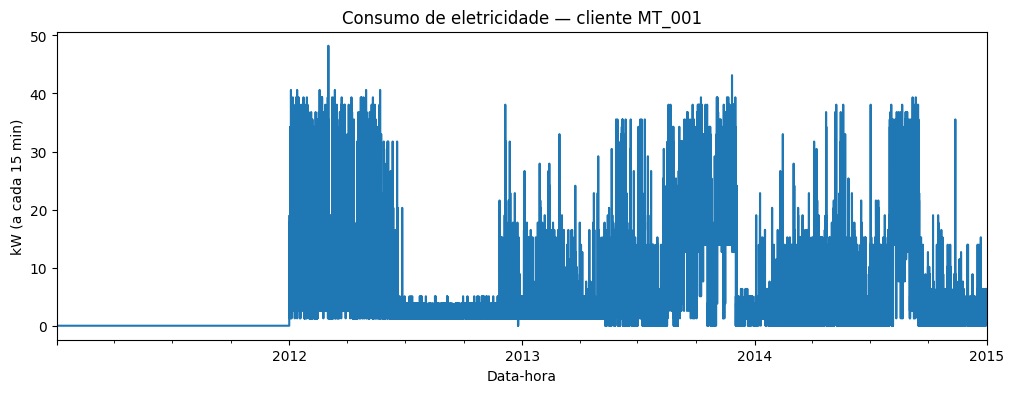

In [1]:
import os
import requests, zipfile, io
import pandas as pd

# 1) Download do dataset (zip + txt)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/uci_electricity/")  # vai criar a pasta

# 2) Carregar em pandas
filepath = os.path.join("data/uci_electricity", "LD2011_2014.txt")
df = pd.read_csv(
    filepath,
    sep=";",
    decimal=",",
    index_col=0
)
df.index = pd.to_datetime(df.index)  # converte o índice para datetime

df.head()

# 3) Inspeção inicial
print("Dimensões:", df.shape)
print("Head:")
print(df.head())
print("Tail:")
print(df.tail())

# 4) Exemplo: plotar uma das séries (por cliente)
import matplotlib.pyplot as plt
cliente = df.columns[0]  # por exemplo o primeiro cliente
df[cliente].plot(figsize=(12,4))
plt.title(f"Consumo de eletricidade — cliente {cliente}")
plt.xlabel("Data-hora")
plt.ylabel("kW (a cada 15 min)")
plt.show()


# RNN base temporal


In [ ]:
# =========================================
# IMPORTS
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM   # <-- troquei Conv1D, MaxPooling1D, Flatten por LSTM
from keras.callbacks import EarlyStopping

# ... (tudo igual até o reshape em trainX/testX)

# =========================================
# 5) DEFINIR A REDE LSTM
# =========================================
model = Sequential()
# LSTM "1D": sequência de 96 passos, 1 feature por passo
model.add(
    LSTM(
        units=64,
        activation="tanh",            # padrão de LSTM
        recurrent_activation="sigmoid",
        input_shape=(WINDOW_SIZE, 1)
    )
)
# camada totalmente conectada depois da LSTM
model.add(Dense(100, activation='relu'))
model.add(Dense(1))  # saída contínua para regressão

model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

# =========================================
# 6) EARLY STOPPING
# =========================================
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# =========================================
# 7) TREINAMENTO
# =========================================
history = model.fit(
    trainX, trainy,
    validation_data=(testX, testy),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# =========================================
# 8) PREDIÇÃO + DESNORMALIZAÇÃO
# =========================================
pred_scaled = model.predict(testX).flatten()

y_true = scaler.inverse_transform(testy.reshape(-1,1)).flatten()
y_pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

# =========================================
# 9) MÉTRICAS
# =========================================
mae = np.mean(np.abs(y_true - y_pred))
mse = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

print("\n===== RESULTADOS =====")
print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)
print("R²  :", r2)

# =========================================
# 10) PLOTS
# =========================================
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss vs Val_Loss (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_true, label='Real')
plt.plot(y_pred, label='Previsto (LSTM-1D)')
plt.title("Real vs Previsto (LSTM-1D)")
plt.xlabel("Tempo")
plt.ylabel("Consumo (kW)")
plt.legend()
plt.grid(True)
plt.show()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,497 (91.79 KB)

 Trainable params: 23,497 (91.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - loss: 10.6224 - val_loss: 1.6245
Epoch 2/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - loss: 4.5053 - val_loss: 1.7235
Epoch 3/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - loss: 4.6988 - val_loss: 1.6282
Epoch 4/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - loss: 4.3540 - val_loss: 1.7285
Epoch 5/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - loss: 4.2182 - val_loss: 1.7676
Epoch 6/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - loss: 4.3226 - val_loss: 1.8433
Epoch 7/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - loss: 4.2408 - val_loss: 1.7724
Epoch 8/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - loss: 4.4999 - val_loss: 1.6691
Epoch 9/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - loss: 4.2816 - val_loss: 1.6003
Epoch 10/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - loss: 4.2069 - val_loss: 1.6329
Epoch 11/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - loss: 4.1333 - val_loss: 1.7104
Epoch 12/100
